# Histogram of Oriented Gradients for Western Blot Forensics

Histogram of oriented gradients(HOG) is a feature-based algorithm to extract descriptor vectors from interest points. Combining HOG with the blotExtractorWatershed western blot interest point detector, we can construct rotation, scale, and contrast/brightness invariant descriptors. 

This notebook will give a brief overview of HOG implementation for western blot images with the following sections:

1. Resampling interest point into blocks
2. Computing the gradient over blocks
3. Building oriented histograms over spacial bins

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import wbMomentsFingerprint as wb
import wbFingerprintUtils as utils
%matplotlib notebook

<IPython.core.display.Javascript object>


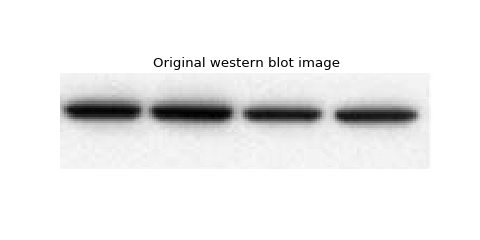

In [2]:
## Create fingerprint object
WB = wb.WesternBlot("C:/Users/Joel/Documents/GitHub/westernBlotForensics/wbFingerprints/testBlots/wb10.jpg")
WB.westernBlotExtractor()
## show original image:
plt.figure(figsize=(6,3))
plt.imshow(WB.image_gray, "gray")
plt.title("Original western blot image")
plt.axis("off");

## 1. Sampling Interest Points

Resampling interest points is done to make the features invariant over the scale space. Also, resampling lowers the computational load. 

Here, we will resample the original interest point array into a 6x24 rectangular grid. We use a smaller width than length because western blots can be simplified down to ellipses with two-fold greater length than width. 

Note: Interest points are "pre-rotation-normalized". The global orientation of the interest point is determined by least-squares fitting an ellipse to the blot contour. Blot interest points are then rotated by the angle between the principal major-axis of the ellipse and the horizontal axis.

Also note: Other block sizes can also be used. Future experiments will test the efficiency of using different block sizes and different resampling methods. Nearest neighbor interpolation in currently being utilized.

<IPython.core.display.Javascript object>


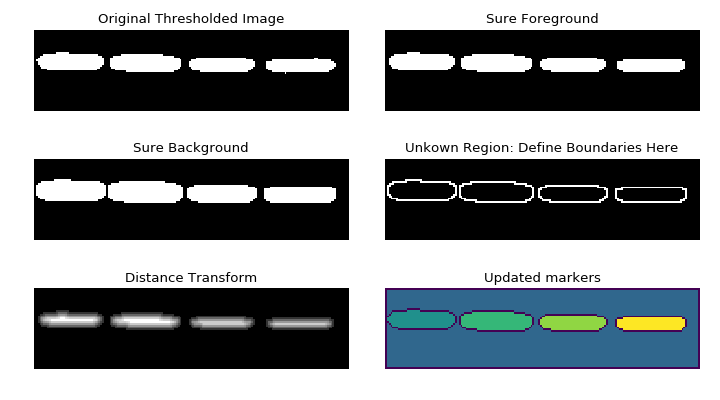

<IPython.core.display.Javascript object>


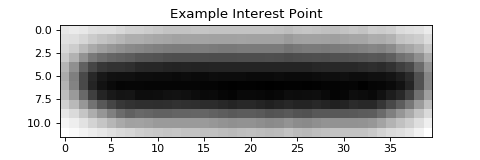

<IPython.core.display.Javascript object>


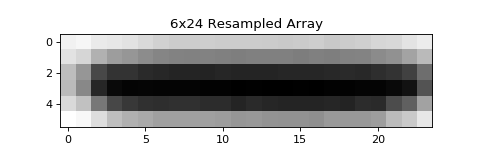

In [3]:
WB.blotExtractorWatershed(255)
exp = WB.fingerprint["blots"][1]

## show example interest point
plt.figure(figsize=(6,2));
plt.imshow(exp, "gray");
plt.title("Example Interest Point");


## Perform HOG on blot:
rsmpld_image, rsmpld_Gkernel, gx, gy, feature_vector = utils.HOG(exp,
                                                              blockShape = (6,24),
                                                              binShape = (2,4),
                                                              orientations = 8,
                                                              L2_NORMALIZE = True, 
                                                              Visualize = True)
## show resampled interest point
plt.figure(figsize=(6,2));
plt.imshow(rsmpld_image, "gray");
plt.title("6x24 Resampled Array");



## 2. Compute The Gradient Across Blocks

Now that we have resampled the original interest point, we can compute the gradiant over the blocks. Each block will be assigned a gradient magnitude and direction. Gradients are calculated in both x (gx) and y (gy) directions with centered Sobel filters. Magnitude and orientation arrays are calculated as follows:

$$
Magnitude := \sqrt{g_{x}^{2} + g_{y}^{2}}
$$
$$
Orientation := \tan^{-1}{\frac{g_{y}}{g_{x}}}
$$

The magnitude array is then weighted by a gaussian function with variance equal to 1/2 each spatial dimension, or (3,12) for each spatial dimension respectively. This gaussian filter is used to assign more weight to the central blocks of the array. This hopefully avoids slight errors from shifts in interest point detection.

<IPython.core.display.Javascript object>


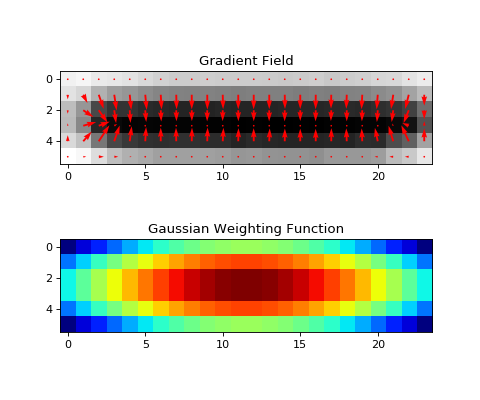

In [4]:
X,Y = np.meshgrid(np.arange(0,24), np.arange(0,6))
f, a = plt.subplots(2,1, figsize = (6,5));
a[0].quiver(-gx, gy, units='width', color="red", scale = 3000);
a[0].imshow(rsmpld_image, "gray"), a[0].set_title("Gradient Field");
a[1].imshow(rsmpld_Gkernel, cmap="jet"), a[1].set_title("Gaussian Weighting Function");


## 3. Build Oriented Histograms Over Spatial Bins

The gradient field that was calculated before is now broken into a 2x4 grid of spatial bins. Within each of the 8 spatial bins, 8 orientation directions (evenly spaced 0:360) are sampled. Magnitudes are accumulated within a spatial bin at each orientation. The final descriptor vector is 2x4x8 = 64 dimensions (2x4 = 8 spatial bins and 8 orientation bins).   

Note: different amounts of spatial and orientation bins can be used. Future experiments will test the efficiecy/perfomance for different bin sizes.

Note: Magnitudes at each orientation are accumulated over each spatial bin. The accumulation procedure has no interpolation across orientation bins. Perhaps implementing interpolation could improve performance for the descriptor.


<IPython.core.display.Javascript object>


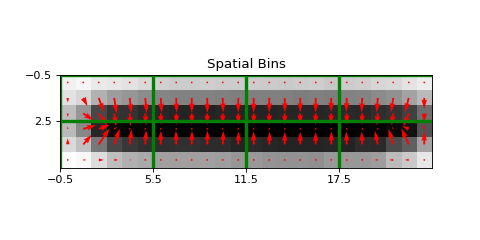

<IPython.core.display.Javascript object>


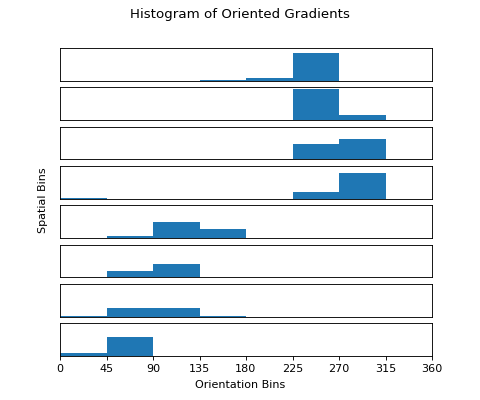

In [5]:
## Break gradient field into 2x4 (8 total) spatial bins
f, a = plt.subplots(1, figsize = (6,3));
a.quiver(-gx, gy, units='width', color="red", scale = 3000);
a.imshow(rsmpld_image, "gray")
a.set_title("Spatial Bins")
a.set_xticks(np.arange(-.5,23.5,6), minor=False)
a.set_yticks(np.arange(-.5,5.5,3), minor=False)
a.xaxis.grid(color="green", linewidth=3, linestyle='-')
a.yaxis.grid(color="green", linewidth=3, linestyle='-')

## compute HOG
f, axis = plt.subplots(8,1, figsize=(6,5))
i=0
for a in axis:
    a.bar(np.arange(45/2, 360+45/2, 45), feature_vector[i:i+8], width=45)
    a.set_ylim(0,.5)
    a.set_xlim(0,360)
    a.yaxis.set_visible(False)
    
    if i+8<64:
        a.xaxis.set_visible(False)
    else:
        a.set_xticks(np.arange(0, 405, 45), minor=False)
    i+=8
f.suptitle("Histogram of Oriented Gradients")
f.text(0.5, 0.03, 'Orientation Bins', ha='center')
f.text(0.08, 0.5, 'Spatial Bins', va='center', rotation='vertical')

